In order to successfully complete this assignment you must do the required reading, watch the provided videos and complete all instructions.  The embedded survey form must be entirely filled out and submitted on or before **11:59pm**.  Students must come to class the next day prepared to discuss the material covered in this assignment. 

---


# PCA 20: Scheduling CUDA Jobs


### Goals for today's pre-class assignment 

1. [2D Array Indexing (a review)](#2D-Array-Indexing)
2. [Indexing a Kernel using Blocks and Grids](#Indexing-a-Kernel-using-Blocks-and-Grids)
3. [Launching a Kernel](#Launching-a-Kernel)
4. [Branch Divergence](#Branch-Divergence)
5. [Assignment wrap up](#Assignment-wrap-up)



---
<a name=2D-Array-Indexing></a>
# 1. 2D Array Indexing (a review)




All memory in a computer is stored linearly with each location in memory given a sequential address.  I want you to think for a moment to understand how we take a linear list of numbers and turn it into a 2D array:

In the following image you can see the relationship between a linear index and a imposed structure that we give it to represent the row and column of the array. We will set up the problem similar to a checker board, such that each grid has a linear label, an index of row, and an index of column. 

<img src="https://lh5.googleusercontent.com/tpc1tFPULkPDt1q03E1nPkllHRO60jYyL-rZWmiJLM0AQtVkm1-EF6Pf0yKrm6S5ifVxJ1knHLpVRv7Fsu_pP-rzrauVa2dp2DLrAx2iya9Jbqs2gRWJJ3J-uBqE=w740" alt = "Visual relationship between linear index and a 2D index" width=600 />

To practice, lets make a few simple python functions that convert the incremental label of a grid point to it's corresponding row and column index. For example, in the above ($99 \times 49$) grid the 99-th item is at row = 2 and col = 1 . 

&#9989; **<font color=red>DO THIS:</font>** Write a function named ```LabelToIndex``` which takes in three arguments (Number of rows, Number of column and the linear index).  The function should then return the row and column for that index. The following is a stub function to get you started:

In [20]:
def LabelToIndices(n_row, n_col, lab):
    """function for converting linear label of grid to indices of row and column
    
    Run the function with number of rows, number of columns and the index as input:
    
    Usage: 
    
    >>> LabelToIndices(99, 49, 3675)
    (75, 0)
    """
    c = -1
    for i in range(0,n_row):
        for j in range(0,n_col):
            c += 1
            if c == lab:
                return i,j
    return None

In [22]:
help(LabelToIndices)

Help on function LabelToIndices in module __main__:

LabelToIndices(n_row, n_col, lab)
    function for converting linear label of grid to indices of row and column

    Run the function with number of rows, number of columns and the index as input:

    Usage:

    >>> LabelToIndices(99, 49, 3675)
    (75, 0)



Let's test the ```LabelToIndices``` function for 3675-th grid. Print the index of row and column.

In [25]:
LabelToIndices(99, 49, 3675)

(75, 0)

&#9989; **<font color=red>DO THIS:</font>** Using the following stub function as a guide write a function named ```LabelToIndex``` that converts the indices of row and column of a grid to the linear label. For example, the grid at row = 2 and col = 1 is labeled as the 99-th point.

In [29]:
def IndicesToLabel(n_row, n_col, row, col):
    """function for converting row and column indices of a grid to linear label
    
    Usage:
    
    >>> IndicesToLabel(99, 49, 2,1)
    99
    """
    r = -1
    index = -1
    for i in range(n_row):
        c = -1
        r += 1
        for j in range(n_col):
            c += 1
            index += 1
            if r is row and c is col:
                return index
    return None

In [31]:
IndicesToLabel(99, 49, 2, 1)

99


---
<a name=Indexing-a-Kernel-using-Blocks-and-Grids></a>
# 2. Indexing a Kernel using Blocks and Grids




Each Cuda Kernel is a thread that runs inside of a block that runs inside of a grid. This organization is designed to make thread able to efficiently cooperate with each other. The following picture gives you a mental picture of how threads are organized into blocks which are organized into grids.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Block-thread.svg/1280px-Block-thread.svg.png" width=50%>

Each thread knows it's address based on the following variables:
* ```gridDim.x```, ```gridDim.y``` and ```gridDim.z``` The size of the block grid in the ```x```, ```y``` and ```z``` directions.
* ```blockDim.x```, ```blockDim.y``` and ```blockDim.z``` The size of the block grid in the ```x```, ```y``` and ```z``` directions.
* ```threadIdx.x```, ```threadIdx.y``` and ```threadIdx.z``` . The location of the thread in ```x,y,z``` block coordinates.
* ```blockIdx.x```, ```blockIdx.y``` and ```blockIdx.z``` . The location of the block in ```x,y,z``` grid coordinates.

Mony programs do not use all three dimensions.  For example, consider the following CUDA kernel from the last pre-class assignment which only uses 2D example and assumes the ```threadIdx.z``` and ```blockIndx.z``` are zero:

```c++
__global__ void theKernel(float * our_array)
{
    //This is array flattening, (Array Width * Y Index + X Index)
    int index = (gridDim.x * blockDim.x) * \
              (blockIdx.y * blockDim.y + threadIdx.y) + \
              (blockIdx.x * blockDim.x + threadIdx.x);
    our_array[index] = (float) index;
}
```

Here is a simpler one from the Vector Add code which only uses one dimension:

```c++
__global__ void vecAdd(int *A,int *B,int *C,int N)
{
   int i = blockIdx.x * blockDim.x + threadIdx.x;
   C[i] = A[i] + B[i]; 
}
```

&#9989; **<font color=red>QUESTION:</font>** Similar to the above code, how would you calculate a unique index for a three dimensional grid with three dimensional blocks (i.e. take the ```int index``` calculation from above and extend it into three dimensions)?

For each dimension, sum the threadIdx and the product of blockIdx and blockDim. Then, sum them all together.

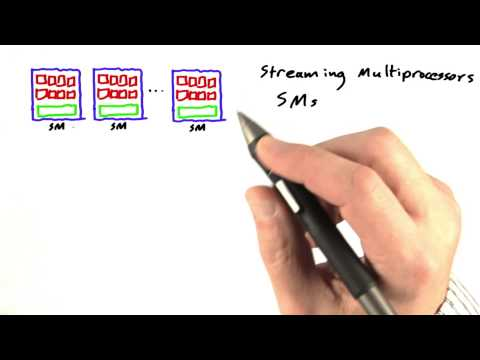

In [35]:
from IPython.display import YouTubeVideo
YouTubeVideo("usY0643pYs8",width=640,height=360)

&#9989; **<font color=red>QUESTION:</font>** What does SM stand for?

Streaming multiprocessors


---
<a name=Launching-a-Kernel></a>
# 3. Launching a Kernel



In the last pre-class the Kernel (shown above) was lanched using the following code:

```c++
dim3 gridSize(2,2,1);
dim3 blockSize(8,8,1);
theKernel <<<gridSize, blockSize>>> (our_array_d);
```

And the Vector Add example from class used the following code:

```c++
int n=10000000;
int block_size=1024;
int block_no = n/block_size;
dim3 dimGrid(block_no,1,1);
dim3 dimBlock(block_size,1,1);
vecAdd<<<block_no,block_size>>>(a_d,b_d,c_d,n);
```

The following video tries to explain this syntax:

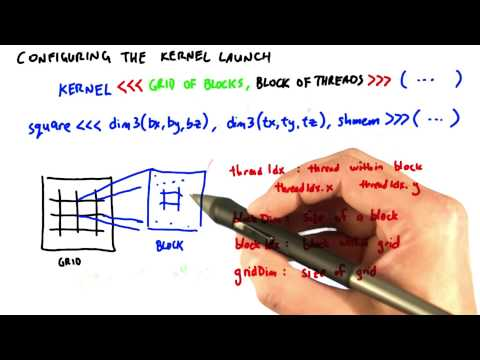

In [38]:
from IPython.display import YouTubeVideo
YouTubeVideo("yNs8B1VnMAA",width=640,height=360)

Consider the following Kernel Call described at the end of the above video:

```c++
Kernel <<<dim3(8,4,2), dim3(16,16)>>>(...)
```

&#9989; **<font color=red>QUESTION:</font>** How many blocks are there?

64

&#9989; **<font color=red>QUESTION:</font>** How many Threads per block?

In [41]:
print(16*16)

256


&#9989; **<font color=red>QUESTION:</font>** How many total threads?

In [43]:
print(64*256)

16384




---
<a name=Branch-Divergence></a>
# 4. Branch Divergence



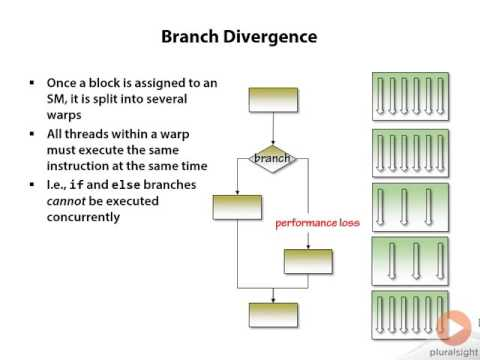

In [45]:
from IPython.display import YouTubeVideo
YouTubeVideo("cYw7VsyVTe4",width=640,height=360)

&#9989; **<font color=red>QUESTION:</font>** What is Branch Divergence and why it is bad?

Because all processes within a warp (smaller grouping of threads inside of blocks) runs concurrently.



---
<a name=Assignment-wrap-up></a>
# 5. Assignment wrap up


Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credits for the assignment!**

[Direct Link to Suvey Form](https://cmse.msu.edu/cmse401-pc-survey)



&#9989; **<font color=red>Assignment-Specific QUESTION:</font>**  Are you able to get the index code review working? If not, where did you get stuck?

yes

&#9989; **<font color=red>QUESTION:</font>**  Summarize what you did in this assignment.

learned about kernel structure and possible issues stemming from how gpus work (branch divergence)

&#9989; **<font color=red>QUESTION:</font>**  What questions do you have, if any, about any of the topics discussed in this assignment after working through the jupyter notebook?

none

&#9989; **<font color=red>QUESTION:</font>**  How well do you feel this assignment helped you to achieve a better understanding of the above mentioned topic(s)?

good

&#9989; **<font color=red>QUESTION:</font>** What was the **most** challenging part of this assignment for you? 

understanding the syntax

&#9989; **<font color=red>QUESTION:</font>** What was the **least** challenging part of this assignment for you? 

making the index functions

&#9989; **<font color=red>QUESTION:</font>**  What kind of additional questions or support, if any, do you feel you need to have a better understanding of the content in this assignment?

none

&#9989; **<font color=red>QUESTION:</font>**  Do you have any further questions or comments about this material, or anything else that's going on in class?

no

&#9989; **<font color=red>QUESTION:</font>** Approximately how long did this pre-class assignment take?

about a hour

In [59]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://cmse.msu.edu/cmse401-pc-survey" 
	width="100%" 
	height="500px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)



---------
### Congratulations, we're done!

To get credit for this assignment you must fill out and submit the above survey from on or before the assignment due date.

Written by Dr. Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----

----